In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [3]:
train.head()

,ID,Yoruba,English
0,ID_AAJEQLCz,A ṣètò Ìgbìmọ̀ Tó Ń Ṣètò Ìrànwọ́ Nígbà Àjálù láti wá bí àwọn ará wa níbẹ̀ ṣe máa rí àwọn nǹkan tí wọ́n máa nílò lọ́jọ́ iwájú.,A Disaster Relief Committee was formed to organize the long-term relief efforts.
1,ID_AASNedba,"Ìrọ̀lẹ́ May 22, 2018 ni wọ́n fàṣẹ ọba mú Arákùnrin Solovyev ní ibùdókọ̀ ojú irin nígbà tí òun àti Anna ìyàwó rẹ̀ ń bọ̀ láti ìrìn-àjò tí wọ́n lọ lórílẹ̀-èdè míì.","Brother Solovyev was arrested on the evening of May 22, 2018, at a railway station, as he was arriving home from a trip abroad with his wife, Anna."
2,ID_AAeQrhMq,Iléeṣẹ́ Creative Commons náà,Creative Commons the Organization
3,ID_AAxlMgPP,"Pè̩lú Egypt, Morocco àti Tunisia tí wó̩n ti lo̩lé, Senegal nìkan lorílè̩èdè adúláwò̩ kan tó kù, wo̩n á fe̩sè̩wo̩nsè̩ pè̩lú Colombia ni ìfe̩sè̩wo̩nsè̩ tó ké̩yìn ikò̩ H ló̩jó̩bò̩.","With Egypt, Morocco and Tunisia out of the World Cup, Senegal, the only African nation left, will take on Columbia in their last group H game on Thursday."
4,ID_ABKuMKSx,"Adájọ́ àgbà lórílẹ̀ èdè Náíjíríà (Attorney General of the Federation), Justice Abubakar Malami ti pàsẹ fún ilé-isẹ́ ọ̀tẹlẹ̀múyẹ́ (Department of State Services, DSS) láti jáwọ́ lórí ẹ̀sun Omoyẹle S...","The Attorney General of the Federation, Justice Abubakar Malami has ordered the Department of State Services (DSS) to hands off the trial of Omoyele Sowore."


**Text Preprocessing**

In [4]:
# make both languages an array
import numpy as np
a = train[['Yoruba', 'English']]
a = np.array(a)

a

array([['A ṣètò Ìgbìmọ̀ Tó Ń Ṣètò Ìrànwọ́ Nígbà Àjálù láti wá bí àwọn ará wa níbẹ̀ ṣe máa rí àwọn nǹkan tí wọ́n máa nílò lọ́jọ́ iwájú.',
        'A Disaster Relief Committee was formed to organize the long-term relief efforts.'],
       ['Ìrọ̀lẹ́ May 22, 2018 ni wọ́n fàṣẹ ọba mú Arákùnrin Solovyev ní ibùdókọ̀ ojú irin nígbà tí òun àti Anna ìyàwó rẹ̀ ń bọ̀ láti ìrìn-àjò tí wọ́n lọ lórílẹ̀-èdè míì.',
        'Brother Solovyev was arrested on the evening of May 22, 2018, at a railway station, as he was arriving home from a trip abroad with his wife, Anna.'],
       ['Iléeṣẹ́ Creative Commons náà',
        'Creative Commons the Organization'],
       ...,
       ['Ọ̀mọ ilé ìgbìmọ̀ Aṣojú-ṣòfin tó ń ṣojú Àgbádárìgì Ọ̀gbẹ́ni Joseph Bamgbose ló sọ ọ̀rọ̀ yí lásìkò tó ńgbé o ríyìn fún wọ̣n pé èróngbà ìjọba ló mumú láyà àwọn aka ẹgbẹ́ ilé ìgbìmọ̀ aṣòfin ẹlẹ́ẹ̀kẹjọ, Óní gẹ́gẹ́ bíí ọmọ ilé ìgbìmọ̀ aṣòfin ọ̀hún tisa ipa ribiribi láti mú ayé dẹrùn fún àwọn ènìyàn agbègbè rẹ̀ látàrí ètò ìrónilágbára l

In [5]:
# make a copy of the array
yor_eng = a.copy()

In [6]:
# remove Punctuations
yor_eng[:, 0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in yor_eng[:,0]]

yor_eng[:, 1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in yor_eng[:,1]]

yor_eng

array([['A ṣètò Ìgbìmọ̀ Tó Ń Ṣètò Ìrànwọ́ Nígbà Àjálù láti wá bí àwọn ará wa níbẹ̀ ṣe máa rí àwọn nǹkan tí wọ́n máa nílò lọ́jọ́ iwájú',
        'A Disaster Relief Committee was formed to organize the longterm relief efforts'],
       ['Ìrọ̀lẹ́ May 22 2018 ni wọ́n fàṣẹ ọba mú Arákùnrin Solovyev ní ibùdókọ̀ ojú irin nígbà tí òun àti Anna ìyàwó rẹ̀ ń bọ̀ láti ìrìnàjò tí wọ́n lọ lórílẹ̀èdè míì',
        'Brother Solovyev was arrested on the evening of May 22 2018 at a railway station as he was arriving home from a trip abroad with his wife Anna'],
       ['Iléeṣẹ́ Creative Commons náà',
        'Creative Commons the Organization'],
       ...,
       ['Ọ̀mọ ilé ìgbìmọ̀ Aṣojúṣòfin tó ń ṣojú Àgbádárìgì Ọ̀gbẹ́ni Joseph Bamgbose ló sọ ọ̀rọ̀ yí lásìkò tó ńgbé o ríyìn fún wọ̣n pé èróngbà ìjọba ló mumú láyà àwọn aka ẹgbẹ́ ilé ìgbìmọ̀ aṣòfin ẹlẹ́ẹ̀kẹjọ Óní gẹ́gẹ́ bíí ọmọ ilé ìgbìmọ̀ aṣòfin ọ̀hún tisa ipa ribiribi láti mú ayé dẹrùn fún àwọn ènìyàn agbègbè rẹ̀ látàrí ètò ìrónilágbára lórí ètò Ọ̀gbìn

In [7]:
# convert to lowercase
for i in range(len(yor_eng)):
  yor_eng[i, 0] = yor_eng[i, 0].lower()
  yor_eng[i, 1] = yor_eng[i, 1].lower()

yor_eng

array([['a ṣètò ìgbìmọ̀ tó ń ṣètò ìrànwọ́ nígbà àjálù láti wá bí àwọn ará wa níbẹ̀ ṣe máa rí àwọn nǹkan tí wọ́n máa nílò lọ́jọ́ iwájú',
        'a disaster relief committee was formed to organize the longterm relief efforts'],
       ['ìrọ̀lẹ́ may 22 2018 ni wọ́n fàṣẹ ọba mú arákùnrin solovyev ní ibùdókọ̀ ojú irin nígbà tí òun àti anna ìyàwó rẹ̀ ń bọ̀ láti ìrìnàjò tí wọ́n lọ lórílẹ̀èdè míì',
        'brother solovyev was arrested on the evening of may 22 2018 at a railway station as he was arriving home from a trip abroad with his wife anna'],
       ['iléeṣẹ́ creative commons náà',
        'creative commons the organization'],
       ...,
       ['ọ̀mọ ilé ìgbìmọ̀ aṣojúṣòfin tó ń ṣojú àgbádárìgì ọ̀gbẹ́ni joseph bamgbose ló sọ ọ̀rọ̀ yí lásìkò tó ńgbé o ríyìn fún wọ̣n pé èróngbà ìjọba ló mumú láyà àwọn aka ẹgbẹ́ ilé ìgbìmọ̀ aṣòfin ẹlẹ́ẹ̀kẹjọ óní gẹ́gẹ́ bíí ọmọ ilé ìgbìmọ̀ aṣòfin ọ̀hún tisa ipa ribiribi láti mú ayé dẹrùn fún àwọn ènìyàn agbègbè rẹ̀ látàrí ètò ìrónilágbára lórí ètò ọ̀gbìn

**Text 2 Sequence Conversion**

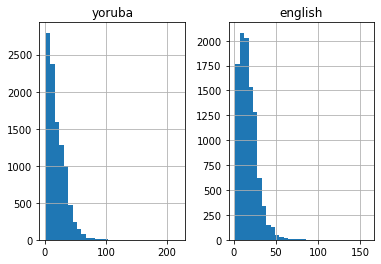

In [8]:
# visualize the length of sentences in both yoruba and english
yor_l, eng_l = [], []

# populate the lists with sentence lengths
for i in yor_eng[:, 0]:
  yor_l.append(len(i.split()))

for i in yor_eng[:, 1]:
  eng_l.append(len(i.split()))

length_df = pd.DataFrame({'yoruba':yor_l, 'english':eng_l})

# counts, bin_edges = np.histogram(length_df)
length_df.hist(bins=30)
plt.show()

looks like the maximum length of yoruba sentence is 200 while that of english is 150

using keras's tokenizer to turn sentences into sequences of integers. Padding will be added to sentences so they all have same length

In [9]:
# function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)

  return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(yor_eng[:, 1])

eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 150
print('English Vocabulary Size: %d' %eng_vocab_size)

English Vocabulary Size: 17108


In [11]:
# prepare Yoruba tokenizer
yor_tokenizer = tokenization(yor_eng[:, 0])

yor_vocab_size = len(yor_tokenizer.word_index) + 1

yor_length = 200
print('Yoruba Vocabulary Size: %d' %yor_vocab_size)

Yoruba Vocabulary Size: 16455


The Code below contains a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above

In [12]:
# encode and padd sequences
def encode_sequence(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # padd sequence with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

**Model Building**

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(yor_eng, test_size=.2, random_state=32)

encoding the yoruba texts as input sequence and english as the output sequence

In [14]:
# prepare training data
trainX = encode_sequence(yor_tokenizer, yor_length, train[:, 0])
trainY = encode_sequence(eng_tokenizer, eng_length, train[:, 1])

# prepare validation data
testX = encode_sequence(yor_tokenizer, yor_length, test[:, 0])
testY = encode_sequence(eng_tokenizer, eng_length, test[:, 1])


Defining our Seq2Seq model architecture

For the encoder, I used an embedding layer and an LSTM layer

For the decoder, I used another LSTM layer followed by a dense layer

In [15]:
# building NMT model

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))

  return model

In [16]:
model = define_model(yor_vocab_size, eng_vocab_size, yor_length, eng_length, 512)

In [17]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [26]:
trainY.reshape(trainY.shape[0], trainY.shape[1])

array([[   10,   351,   374, ...,     0,     0,     0],
       [    1,  1697,   284, ...,     0,     0,     0],
       [ 1364, 14969, 14970, ...,     0,     0,     0],
       ...,
       [   82,    24,    63, ...,     0,     0,     0],
       [    6,   217,     2, ...,     0,     0,     0],
       [  399,   131,    36, ...,     0,     0,     0]], dtype=int32)

In [27]:
filename = "model.h1.trans"
checkpoint = ModelCheckpoint(filepath=filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=1, 
                    batch_size=512, validation_split=0.2, callbacks=[checkpoint], verbose=1)

13/13 [==============================] - 1736s 133s/step - loss: 5.7092 - val_loss: 1.1337

Epoch 00001: val_loss improved from inf to 1.13369, saving model to model.h1.trans


INFO:tensorflow:Assets written to: model.h1.trans/assets


INFO:tensorflow:Assets written to: model.h1.trans/assets


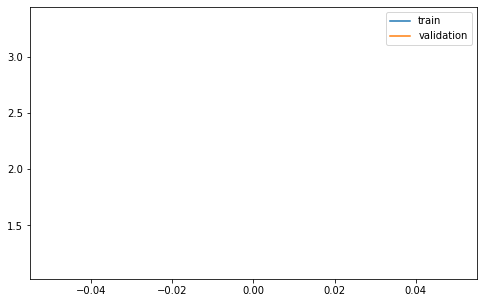

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [30]:
testX.reshape((testX.shape[0], testX.shape[1]))[0]

array([   3,  711,  125,    6,   39,   18,   55,   95,  152,   31,   30,
        277,    4, 2559,   23,  192,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [31]:
# load model and make prediction
model_loaded = load_model('model.h1.trans')
preds = model_loaded.predict_classes(testX.reshape((testX.shape[0], testX.shape[1]))[0])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
# convert predictions to integer
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index=='n':
      return word
  return None

In [36]:
# convert prediciton into English
pred_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)

    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else: temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else: temp.append(t)

      pred_text.append(" ".join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual':test[:,0], 'predicted': pred_text})

In [38]:
print(test[0,0] )
print(pred_text)

ní tàwọn míì ó lè jẹ́ arákùnrin tàbí arábìnrin kan nínú ìjọ tó ṣòroó bá lò
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
